In [1]:
import os
import pandas as pd
root_dir = 'C:\Vinh\Python\Machine Learning\Skin condition detection\Kaggle\IMG_CLASSES'

image_paths = []
labels = []

labels_dict = {
    "1. Eczema 1677": "Eczema",
    "2. Melanoma 15.75k": "Melanoma",
    "4. Basal Cell Carcinoma (BCC) 3323": "Basal Cell Carcinoma",
    "5. Melanocytic Nevi (NV) - 7970": "Melanocytic Nevi",
    "6. Benign Keratosis-like Lesions (BKL) 2624": "Benign Keratosis-like Lesions",
    "7. Psoriasis pictures Lichen Planus and related diseases - 2k": "Psoriasis pictures Lichen Planus and related diseases",
    "8. Seborrheic Keratoses and other Benign Tumors - 1.8k": "Seborrheic Keratoses and other Benign Tumors",
    "9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k": "Tinea Ringworm Candidiasis and other Fungal Infections",
    "10. Warts Molluscum and other Viral Infections - 2103": "Warts Molluscum and other Viral Infections"
}

for label in os.listdir(root_dir):
    if label != "3. Atopic Dermatitis - 1.25k":
        label_dir = os.path.join(root_dir, label)
        if os.path.isdir(label_dir):
            for filename in os.listdir(label_dir):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')): 
                    image_paths.append(os.path.join(label_dir, filename))
                    labels.append(labels_dict[label])

df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

df = df.sample(frac=1).reset_index(drop=True)

print(df.head())

                                          image_path  \
0  C:\Vinh\Python\Machine Learning\Skin condition...   
1  C:\Vinh\Python\Machine Learning\Skin condition...   
2  C:\Vinh\Python\Machine Learning\Skin condition...   
3  C:\Vinh\Python\Machine Learning\Skin condition...   
4  C:\Vinh\Python\Machine Learning\Skin condition...   

                           label  
0               Melanocytic Nevi  
1  Benign Keratosis-like Lesions  
2                         Eczema  
3                       Melanoma  
4               Melanocytic Nevi  


C:\Users\Vinh\AppData\Local\Temp\ipykernel_27468\2210118981.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)


<Axes: xlabel='label'>

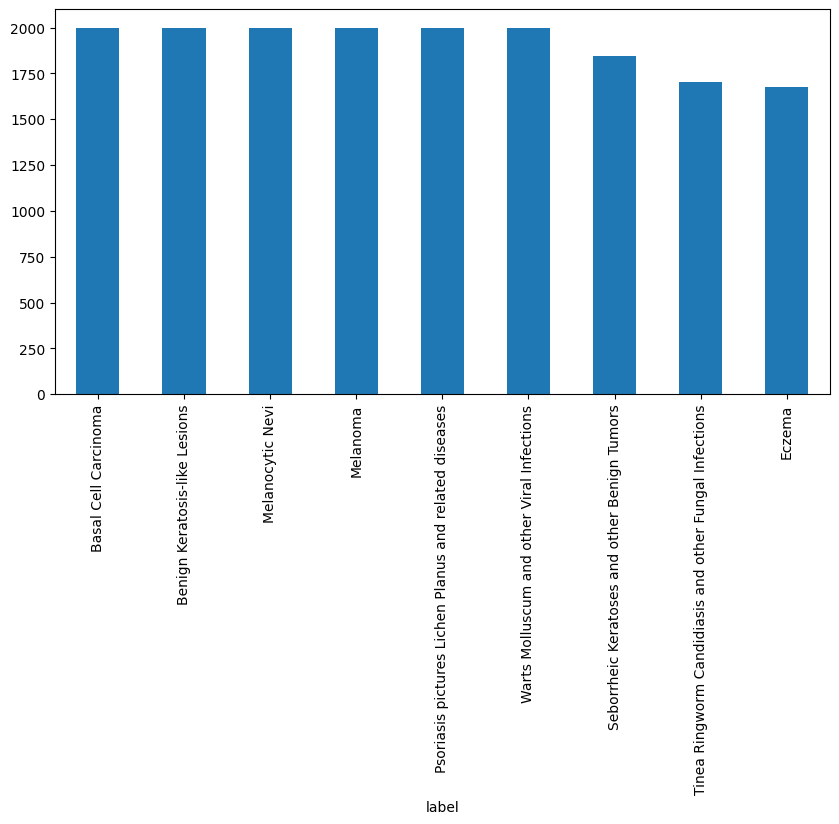

In [4]:
max_images_per_class = 2000

df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
df['label'].value_counts().plot(kind='bar', ax=ax1)

In [6]:
import torch

# Clear CUDA cache
torch.cuda.empty_cache()

# Check CUDA availability and devices
print("CUDA Available: ", torch.cuda.is_available())
print("CUDA Device Count: ", torch.cuda.device_count())


CUDA Available:  True
CUDA Device Count:  1


In [3]:
import collections
import copy
import hashlib
import io
import os
import subprocess
import textwrap
import time

from typing import List, Text

from PIL import Image

import numpy as np
import pandas as pd
import tabulate


import tensorflow as tf

import matplotlib.pyplot as plt

In [5]:
condition_to_index = {condition: idx for idx, condition in enumerate(labels_dict.values())}

print(condition_to_index)
def conditions_to_binary_matrix(condition, condition_to_index):
    binary_matrix = np.zeros(len(condition_to_index))
    if condition in condition_to_index:
        binary_matrix[condition_to_index[condition]] = 1
    return binary_matrix
binary_labels = np.array([conditions_to_binary_matrix(cond, condition_to_index)
                          for cond in df["label"]])

print(len(binary_labels))
print(binary_labels)
print(binary_labels[5])

{'Eczema': 0, 'Melanoma': 1, 'Basal Cell Carcinoma': 2, 'Melanocytic Nevi': 3, 'Benign Keratosis-like Lesions': 4, 'Psoriasis pictures Lichen Planus and related diseases': 5, 'Seborrheic Keratoses and other Benign Tumors': 6, 'Tinea Ringworm Candidiasis and other Fungal Infections': 7, 'Warts Molluscum and other Viral Infections': 8}
17226
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
[0. 0. 1. 0. 0. 0. 0. 0. 0.]


Image shape: (100, 75, 3)
Image min value: 0.0
Image max value: 0.9372549057006836


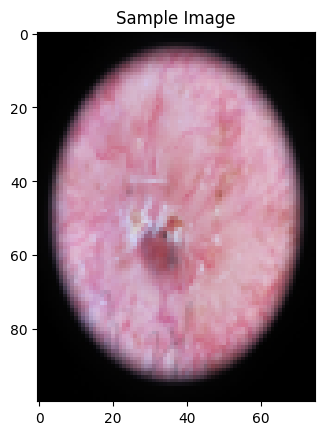

In [6]:
def load_and_preprocess_image(image_path, target_size=(75, 100)):
    try:
        image = Image.open(image_path).convert('RGB')
        image = image.resize(target_size)
        image = np.array(image, dtype=np.float32) / 255.0
        return image
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return np.zeros(target_size + (3,), dtype=np.float32)
image_path = df["image_path"][0]
image = load_and_preprocess_image(image_path)
print(f"Image shape: {image.shape}")
print(f"Image min value: {image.min()}")
print(f"Image max value: {image.max()}")

plt.imshow(image)
plt.title("Sample Image")
plt.show()

In [7]:
from torchvision import transforms
from PIL import Image
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed

def load_and_preprocess_image(path, target_size):
    img = Image.open(path).convert('RGB')
    img = img.resize(target_size)
    img = np.array(img) / 255.0
    return img


def process_images(df, batch_size=100, target_size=(75, 100), max_workers=8):
    all_images = []
    
    def load_image(path):
        return load_and_preprocess_image(path, target_size)
    
    num_images = len(df)
    
    for start in range(0, num_images, batch_size):
        batch_paths = df['image_path'].iloc[start:start + batch_size]
        batch_images = []
        
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            futures = [executor.submit(load_image, path) for path in batch_paths]
            for future in as_completed(futures):
                img = future.result()
                if img.max() == 0:
                    print(f"Warning: Image in batch is all zeros.")
                batch_images.append(img)

        all_images.append(np.array(batch_images, dtype=np.float32))
    
    return np.concatenate(all_images, axis=0)

batch_size = 100  
images = process_images(df, batch_size=batch_size)

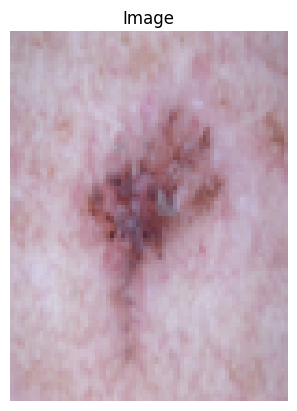

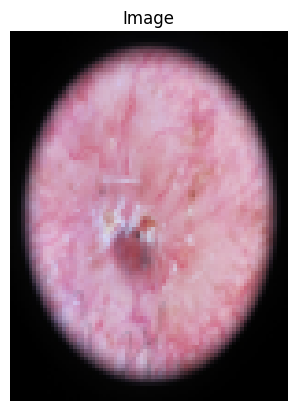

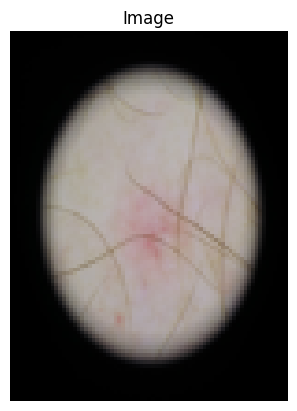

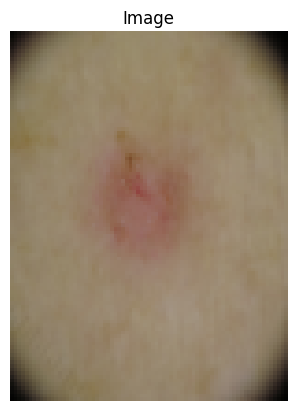

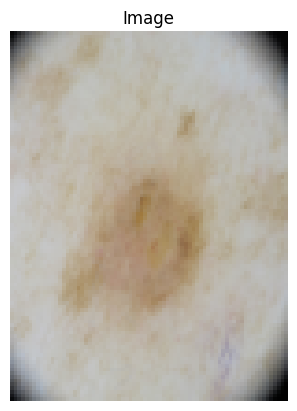

In [8]:
import matplotlib.pyplot as plt

def show_image(image, title="Image"):
    if image.ndim == 3 and image.shape[2] == 3:  
        plt.imshow(image)
    else:
        plt.imshow(image, cmap='gray') 
    plt.title(title)
    plt.axis('off')
    plt.show()
for i in range(5):
    show_image(images[i])

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(images, binary_labels, test_size=0.2, random_state=1234)

In [10]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

print("Number of samples in X_train:", X_train.shape[0])
print("Number of samples in X_val:", X_val.shape[0])
print("Number of samples in y_train:", y_train.shape[0])
print("Number of samples in y_val:", y_val.shape[0])

X_train shape: (13780, 100, 75, 3)
X_val shape: (3446, 100, 75, 3)
y_train shape: (13780, 9)
y_val shape: (3446, 9)
Number of samples in X_train: 13780
Number of samples in X_val: 3446
Number of samples in y_train: 13780
Number of samples in y_val: 3446


In [11]:
from PIL import Image
import torch

def preprocess_image(image):
    if isinstance(image, np.ndarray):
        if image.ndim == 3 and image.shape[2] == 3:  # RGB image
            # Ensure the image is in the correct format
            return (np.transpose(image, (1, 2, 0)) * 255).astype(np.uint8)
        elif image.ndim == 2:  # Grayscale image
            return np.expand_dims(image, axis=-1)
        else:
            raise ValueError("Unexpected image format: shape {}".format(image.shape))
    else:
        raise TypeError("Expected numpy array, got {}".format(type(image)))


class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Preprocess the image based on its type
        image = preprocess_image(image)

        # Convert to PIL image
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, label


In [12]:
from torchvision import transforms
from torch.utils.data import DataLoader

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.RandomResizedCrop(size=(75, 100), scale=(0.9, 1.0)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.RandomAffine(degrees=0, shear=20),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1)
    ),
    transforms.ToTensor()
])

val_transforms = transforms.Compose([
    transforms.Resize((75, 100)),
    transforms.ToTensor()
])

train_dataset = AugmentedDataset(images=X_train, labels=y_train, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)

val_dataset = AugmentedDataset(images=X_val, labels=y_val, transform=val_transforms)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

Images batch shape: torch.Size([32, 3, 75, 100])
Labels batch shape: torch.Size([32, 9])


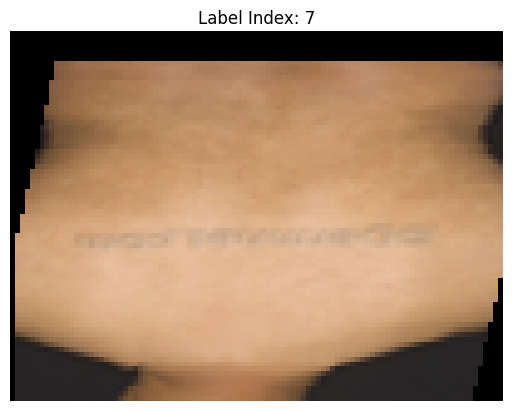

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def preprocess_image(image):
    if len(image.shape) == 3:  
        return (image * 255).astype(np.uint8)  
    elif len(image.shape) == 4:
        return (image[0] * 255).astype(np.uint8)
    else:
        raise ValueError("Unexpected image format.")

def visualize_batch(train_loader):
    for images, labels in train_loader:
        print(f"Images batch shape: {images.shape}")
        print(f"Labels batch shape: {labels.shape}")
        
        image = images[0].permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
        
        if image.shape[2] == 1:  # Grayscale image
            image = image[:, :, 0]
        elif image.shape[2] == 3:  # RGB image
            pass
        else:
            raise ValueError("Unexpected image format for visualization.")
        
        plt.imshow(image)
        plt.axis('off')
        
        label = labels[0].numpy()
        label_index = np.argmax(label) 
        plt.title(f"Label Index: {label_index}")
        
        plt.show()
        break  

visualize_batch(train_loader)




In [4]:
import torch
import torch.nn as nn
from torchvision import models
from torchinfo import summary

class CustomDenseNet121(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomDenseNet121, self).__init__()
        self.base_model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        self.base_model.classifier = nn.Identity()  

        self.fc1 = nn.Linear(1024, 512) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.base_model(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomDenseNet121(num_classes=9).to(device)

dummy_input = torch.randn(1, 3, 75, 100).to(device)

model(dummy_input)

summary(model, input_size=(1, 3, 75, 100))

Layer (type:depth-idx)                        Output Shape              Param #
CustomDenseNet121                             [1, 9]                    --
├─DenseNet: 1-1                               [1, 1024]                 --
│    └─Sequential: 2-1                        [1, 1024, 2, 3]           --
│    │    └─Conv2d: 3-1                       [1, 64, 38, 50]           9,408
│    │    └─BatchNorm2d: 3-2                  [1, 64, 38, 50]           128
│    │    └─ReLU: 3-3                         [1, 64, 38, 50]           --
│    │    └─MaxPool2d: 3-4                    [1, 64, 19, 25]           --
│    │    └─_DenseBlock: 3-5                  [1, 256, 19, 25]          335,040
│    │    └─_Transition: 3-6                  [1, 128, 9, 12]           33,280
│    │    └─_DenseBlock: 3-7                  [1, 512, 9, 12]           919,680
│    │    └─_Transition: 3-8                  [1, 256, 4, 6]            132,096
│    │    └─_DenseBlock: 3-9                  [1, 1024, 4, 6]           

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max', 
    factor=0.5, 
    patience=3, 
    min_lr=1e-5
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def one_hot_to_class_indices(one_hot_labels):
    return one_hot_labels.argmax(dim=1)

def train_model(model, train_loader, criterion, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader, desc="Training", unit="batch"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        class_indices = one_hot_to_class_indices(labels)
        loss = criterion(outputs, class_indices)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == class_indices).sum().item()
        total += labels.size(0)
    
    avg_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Training Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

def evaluate_model(model, val_loader, criterion, scheduler, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", unit="batch"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, one_hot_to_class_indices(labels))  
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += one_hot_to_class_indices(labels).size(0) 
            correct += (predicted == one_hot_to_class_indices(labels)).sum().item() 

    avg_loss = running_loss / len(val_loader)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    
    scheduler.step(accuracy)
    return avg_loss


In [17]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss - val_loss > self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True



early_stopping = EarlyStopping(patience=5)
num_epochs = 50

for epoch in range(num_epochs):
    print(device)
    train_model(model, train_loader, criterion, optimizer, scheduler, device)
    val_loss = evaluate_model(model, val_loader, criterion, scheduler, device)

    early_stopping(val_loss)

    if early_stopping.early_stop:
        print("Early stopping")
        break


cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:50<00:00,  3.89batch/s]


Training Loss: 1.9257, Accuracy: 46.71%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:07<00:00, 14.11batch/s]


Validation Loss: 1.8740, Accuracy: 51.60%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:50<00:00,  3.91batch/s]


Training Loss: 1.8514, Accuracy: 53.24%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:07<00:00, 14.07batch/s]


Validation Loss: 1.7952, Accuracy: 59.05%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:45<00:00,  4.07batch/s]


Training Loss: 1.8015, Accuracy: 58.36%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:07<00:00, 13.84batch/s]


Validation Loss: 1.7647, Accuracy: 61.87%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:50<00:00,  3.90batch/s]


Training Loss: 1.7751, Accuracy: 60.41%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:07<00:00, 14.55batch/s]


Validation Loss: 1.7391, Accuracy: 63.76%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:52<00:00,  3.82batch/s]


Training Loss: 1.7529, Accuracy: 62.45%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:07<00:00, 14.13batch/s]


Validation Loss: 1.7314, Accuracy: 64.39%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:49<00:00,  3.94batch/s]


Training Loss: 1.7423, Accuracy: 63.35%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:07<00:00, 13.83batch/s]


Validation Loss: 1.7310, Accuracy: 64.19%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [02:09<00:00,  3.33batch/s]


Training Loss: 1.7287, Accuracy: 64.87%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:08<00:00, 13.48batch/s]


Validation Loss: 1.7071, Accuracy: 66.22%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:52<00:00,  3.85batch/s]


Training Loss: 1.7256, Accuracy: 64.77%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:07<00:00, 13.84batch/s]


Validation Loss: 1.7051, Accuracy: 66.74%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:53<00:00,  3.81batch/s]


Training Loss: 1.7077, Accuracy: 66.66%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:07<00:00, 13.65batch/s]


Validation Loss: 1.6927, Accuracy: 67.82%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:56<00:00,  3.71batch/s]


Training Loss: 1.6946, Accuracy: 68.10%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:07<00:00, 13.58batch/s]


Validation Loss: 1.6827, Accuracy: 68.98%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:53<00:00,  3.79batch/s]


Training Loss: 1.6863, Accuracy: 69.14%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:07<00:00, 14.48batch/s]


Validation Loss: 1.7030, Accuracy: 66.69%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:54<00:00,  3.76batch/s]


Training Loss: 1.6778, Accuracy: 69.85%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:08<00:00, 13.05batch/s]


Validation Loss: 1.6665, Accuracy: 70.72%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:52<00:00,  3.83batch/s]


Training Loss: 1.6632, Accuracy: 71.19%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:07<00:00, 14.06batch/s]


Validation Loss: 1.6787, Accuracy: 69.30%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:51<00:00,  3.88batch/s]


Training Loss: 1.6578, Accuracy: 71.87%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:07<00:00, 13.85batch/s]


Validation Loss: 1.6664, Accuracy: 70.63%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:48<00:00,  3.98batch/s]


Training Loss: 1.6489, Accuracy: 72.82%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:07<00:00, 14.19batch/s]


Validation Loss: 1.6540, Accuracy: 72.11%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:48<00:00,  3.97batch/s]


Training Loss: 1.6430, Accuracy: 73.34%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:07<00:00, 14.47batch/s]


Validation Loss: 1.6459, Accuracy: 73.04%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:49<00:00,  3.94batch/s]


Training Loss: 1.6320, Accuracy: 74.33%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:07<00:00, 14.93batch/s]


Validation Loss: 1.6543, Accuracy: 71.50%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:48<00:00,  3.96batch/s]


Training Loss: 1.6300, Accuracy: 74.35%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:07<00:00, 14.32batch/s]


Validation Loss: 1.6472, Accuracy: 72.34%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:49<00:00,  3.95batch/s]


Training Loss: 1.6223, Accuracy: 75.29%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:07<00:00, 14.58batch/s]


Validation Loss: 1.6662, Accuracy: 70.55%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:48<00:00,  3.96batch/s]


Training Loss: 1.6178, Accuracy: 75.80%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:07<00:00, 14.41batch/s]


Validation Loss: 1.6430, Accuracy: 73.13%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [21:32<00:00,  3.00s/batch]


Training Loss: 1.6108, Accuracy: 76.57%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:07<00:00, 14.79batch/s]


Validation Loss: 1.6451, Accuracy: 72.55%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:44<00:00,  4.12batch/s]


Training Loss: 1.6072, Accuracy: 76.84%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:07<00:00, 15.11batch/s]


Validation Loss: 1.6380, Accuracy: 73.82%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [47:15<00:00,  6.58s/batch]


Training Loss: 1.6060, Accuracy: 76.80%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:07<00:00, 15.00batch/s]


Validation Loss: 1.6408, Accuracy: 73.30%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:46<00:00,  4.05batch/s]


Training Loss: 1.5978, Accuracy: 77.76%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:07<00:00, 14.96batch/s]


Validation Loss: 1.6424, Accuracy: 72.52%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:48<00:00,  3.99batch/s]


Training Loss: 1.5934, Accuracy: 78.03%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:06<00:00, 15.55batch/s]


Validation Loss: 1.6343, Accuracy: 73.71%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:49<00:00,  3.93batch/s]


Training Loss: 1.5874, Accuracy: 78.66%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:06<00:00, 15.68batch/s]


Validation Loss: 1.6328, Accuracy: 73.91%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:46<00:00,  4.04batch/s]


Training Loss: 1.5873, Accuracy: 78.76%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:07<00:00, 14.45batch/s]


Validation Loss: 1.6317, Accuracy: 74.11%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:49<00:00,  3.93batch/s]


Training Loss: 1.5855, Accuracy: 78.90%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:07<00:00, 14.30batch/s]


Validation Loss: 1.6300, Accuracy: 73.91%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:50<00:00,  3.91batch/s]


Training Loss: 1.5808, Accuracy: 79.37%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:07<00:00, 14.15batch/s]


Validation Loss: 1.6512, Accuracy: 72.29%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:48<00:00,  3.98batch/s]


Training Loss: 1.5780, Accuracy: 79.62%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:07<00:00, 14.05batch/s]


Validation Loss: 1.6314, Accuracy: 74.06%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:48<00:00,  3.97batch/s]


Training Loss: 1.5708, Accuracy: 80.32%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:07<00:00, 14.67batch/s]


Validation Loss: 1.6294, Accuracy: 74.17%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [10:30<00:00,  1.46s/batch]


Training Loss: 1.5685, Accuracy: 80.55%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:07<00:00, 14.18batch/s]


Validation Loss: 1.6307, Accuracy: 74.03%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:48<00:00,  3.98batch/s]


Training Loss: 1.5634, Accuracy: 81.10%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:07<00:00, 14.63batch/s]


Validation Loss: 1.6238, Accuracy: 74.67%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:48<00:00,  3.97batch/s]


Training Loss: 1.5600, Accuracy: 81.48%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:07<00:00, 14.34batch/s]


Validation Loss: 1.6328, Accuracy: 73.82%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:47<00:00,  3.99batch/s]


Training Loss: 1.5641, Accuracy: 81.10%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:07<00:00, 14.37batch/s]


Validation Loss: 1.6258, Accuracy: 74.64%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:50<00:00,  3.90batch/s]


Training Loss: 1.5564, Accuracy: 81.84%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:08<00:00, 12.61batch/s]


Validation Loss: 1.6207, Accuracy: 75.10%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:50<00:00,  3.89batch/s]


Training Loss: 1.5536, Accuracy: 82.15%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:10<00:00, 10.72batch/s]


Validation Loss: 1.6513, Accuracy: 71.88%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:49<00:00,  3.94batch/s]


Training Loss: 1.5501, Accuracy: 82.41%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:08<00:00, 12.47batch/s]


Validation Loss: 1.6107, Accuracy: 75.94%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:50<00:00,  3.89batch/s]


Training Loss: 1.5511, Accuracy: 82.42%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:08<00:00, 13.16batch/s]


Validation Loss: 1.6361, Accuracy: 73.74%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:50<00:00,  3.90batch/s]


Training Loss: 1.5439, Accuracy: 83.02%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:09<00:00, 11.83batch/s]


Validation Loss: 1.6108, Accuracy: 76.32%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:49<00:00,  3.95batch/s]


Training Loss: 1.5416, Accuracy: 83.29%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:08<00:00, 12.94batch/s]


Validation Loss: 1.6086, Accuracy: 76.09%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:52<00:00,  3.82batch/s]


Training Loss: 1.5386, Accuracy: 83.62%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:09<00:00, 11.93batch/s]


Validation Loss: 1.6126, Accuracy: 75.89%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:50<00:00,  3.90batch/s]


Training Loss: 1.5386, Accuracy: 83.61%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:08<00:00, 13.35batch/s]


Validation Loss: 1.6111, Accuracy: 76.23%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:49<00:00,  3.94batch/s]


Training Loss: 1.5366, Accuracy: 83.89%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:08<00:00, 13.17batch/s]


Validation Loss: 1.6156, Accuracy: 75.48%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:48<00:00,  3.96batch/s]


Training Loss: 1.5178, Accuracy: 85.75%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:08<00:00, 12.45batch/s]


Validation Loss: 1.6069, Accuracy: 76.52%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:51<00:00,  3.87batch/s]


Training Loss: 1.5094, Accuracy: 86.60%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:08<00:00, 13.27batch/s]


Validation Loss: 1.6055, Accuracy: 76.67%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:49<00:00,  3.94batch/s]


Training Loss: 1.5096, Accuracy: 86.54%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:08<00:00, 13.24batch/s]


Validation Loss: 1.6002, Accuracy: 77.13%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:47<00:00,  4.00batch/s]


Training Loss: 1.5071, Accuracy: 86.75%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:08<00:00, 13.00batch/s]


Validation Loss: 1.6029, Accuracy: 76.76%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:49<00:00,  3.95batch/s]


Training Loss: 1.5037, Accuracy: 87.21%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:08<00:00, 12.97batch/s]


Validation Loss: 1.5977, Accuracy: 77.45%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 431/431 [01:49<00:00,  3.92batch/s]


Training Loss: 1.5038, Accuracy: 87.03%


Validation: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:08<00:00, 13.30batch/s]


Validation Loss: 1.5979, Accuracy: 77.22%


In [61]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import urllib.request
import torch.nn.functional as F

transform = transforms.Compose([
    transforms.Resize((75, 100)),
    transforms.ToTensor(),
])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

image_url = "https://nationaleczema.org/wp-content/uploads/2017/06/eczema.AD_.backoflegs.child_.png"
try:
    with urllib.request.urlopen(image_url) as response:
        img = Image.open(response).convert('RGB')  # Ensure the image is in RGB format

    image = transform(img).unsqueeze(0).to(device)  # Add batch dimension http://nethealthbook.com/wp-content/uploads/2014/10/shutterstock_173552906.jpgand move to device
    
    print_list = []
    
    labels_arr = list(labels_dict.values())

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        print(f"Predicted class index: {predicted.item()}")
        probabilities = F.softmax(outputs, dim=1)
        probabilities = list(probabilities[0])
        
        for idx, probability in enumerate(probabilities):
            probability = float(probability)
            print_list.append((probability, labels_arr[idx]))
        print_list.sort(reverse = True)
        
        for idx, item in enumerate(print_list):
            print(f"Rank {idx+1}: {item[1]} - {item[0]*100}%")
        

    plt.imshow(img)
    plt.title(f'Predicted class: {labels_arr[predicted.item()]}')
    plt.axis('off')
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")


An error occurred: HTTP Error 403: Forbidden


In [18]:
torch.save(model, 'model.pth')

In [4]:
model = torch.load("model2.pth")
model.eval()

C:\Users\Vinh\AppData\Local\Temp\ipykernel_26232\4069797558.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("model2.pth")


CustomDenseNet121(
  (base_model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05,

In [17]:
import torch
import torch.optim as optim
from tqdm import tqdm

def one_hot_to_class_indices(one_hot_labels):
    return one_hot_labels.argmax(dim=1)

def evaluate_model(model, val_loader, criterion, scheduler, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", unit="batch"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, one_hot_to_class_indices(labels))  
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += one_hot_to_class_indices(labels).size(0) 
            correct += (predicted == one_hot_to_class_indices(labels)).sum().item() 

    avg_loss = running_loss / len(val_loader)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    
    scheduler.step(accuracy)
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max', 
    factor=0.5, 
    patience=3, 
    min_lr=1e-5
)

    
evaluate_model(model, val_loader, criterion, scheduler, device)

Validation:   0%|                                                                           | 0/108 [00:00<?, ?batch/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


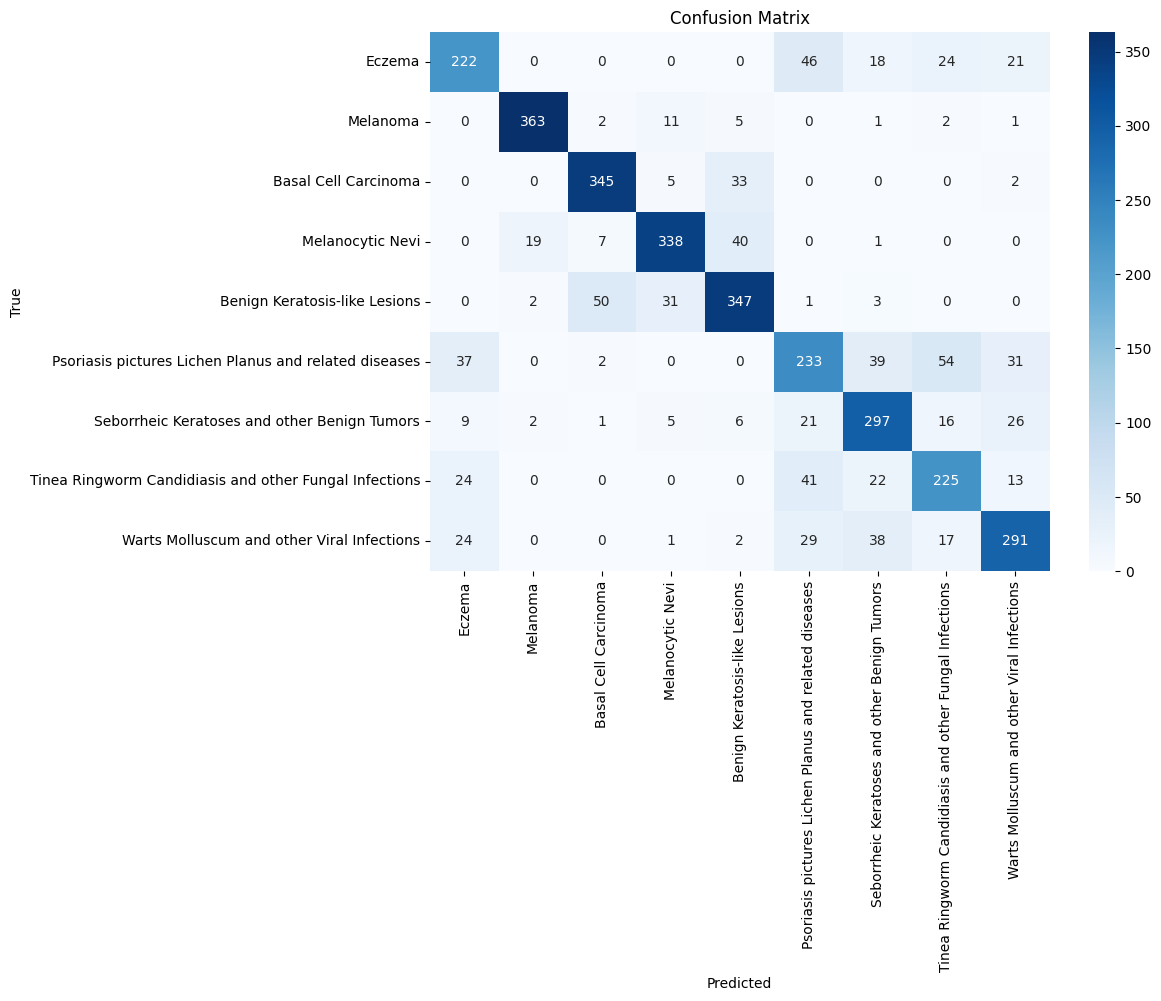

In [19]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def one_hot_to_class_indices(one_hot_labels):
    return one_hot_labels.argmax(dim=1)

# Initialize lists to collect labels and predictions
all_labels = []
all_preds = []

# Evaluate the model
with torch.no_grad():
    model.eval()
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), one_hot_to_class_indices(labels).to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
\
# Convert lists to NumPy arrays and flatten
all_labels = np.array(all_labels).flatten()
all_preds = np.array(all_preds).flatten()

# Ensure the data is of integer type
all_labels = all_labels.astype(int)
all_preds = all_preds.astype(int)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(labels_dict.values()), yticklabels=list(labels_dict.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(all_labels, all_preds, average=None)
recall = recall_score(all_labels, all_preds, average=None)
f1 = f1_score(all_labels, all_preds, average=None)

labels_name = list(labels_dict.values())
for class_id in range(9):
    print(f"Precision for class {labels_name[class_id]}:", precision[class_id])
    print(f"Recall for class {labels_name[class_id]}:", recall[class_id])
    print(f"F1 Score for class {labels_name[class_id]}:", f1[class_id])


Precision for class Eczema: 0.7025316455696202
Recall for class Eczema: 0.6706948640483383
F1 Score for class Eczema: 0.6862442040185471
Precision for class Melanoma: 0.9404145077720207
Recall for class Melanoma: 0.9428571428571428
F1 Score for class Melanoma: 0.9416342412451362
Precision for class Basal Cell Carcinoma: 0.8476658476658476
Recall for class Basal Cell Carcinoma: 0.8961038961038961
F1 Score for class Basal Cell Carcinoma: 0.8712121212121212
Precision for class Melanocytic Nevi: 0.8644501278772379
Recall for class Melanocytic Nevi: 0.8345679012345679
F1 Score for class Melanocytic Nevi: 0.8492462311557789
Precision for class Benign Keratosis-like Lesions: 0.8013856812933026
Recall for class Benign Keratosis-like Lesions: 0.7995391705069125
F1 Score for class Benign Keratosis-like Lesions: 0.8004613610149942
Precision for class Psoriasis pictures Lichen Planus and related diseases: 0.628032345013477
Recall for class Psoriasis pictures Lichen Planus and related diseases: 0.5

In [38]:
import torch
import torch.onnx

model = torch.load('model.pth')
model.eval() 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device) 

dummy_input = torch.randn(1, 3, 75, 100).to(device)

input_names = ['input_image']
output_names = ['output_probs']

torch.onnx.export(
    model, 
    dummy_input, 
    'model.onnx', 
    input_names=input_names,  
    output_names=output_names,  
    verbose=True, 
    opset_version=12  
)


C:\Users\Vinh\AppData\Local\Temp\ipykernel_128768\2731666620.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model.pth')


In [39]:
import onnx

# Load and check the model
onnx_model = onnx.load('model.onnx')
onnx.checker.check_model(onnx_model)

In [40]:
import torch
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO

# Define your class labels
class_labels = [
    'Eczema',
    'Melanoma',
    'Basal Cell Carcinoma',
    'Melanocytic Nevi',
    'Benign Keratosis-like Lesions',
    'Psoriasis pictures Lichen Planus and related diseases',
    'Seborrheic Keratoses and other Benign Tumors',
    'Tinea Ringworm Candidiasis and other Fungal Infections',
    'Warts Molluscum and other Viral Infections'
]

# Load image from URL
def load_image(image_url):
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    return img

def preprocess_image(img):
    preprocess = transforms.Compose([
        transforms.Resize((100, 75)), 
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = preprocess(img).unsqueeze(0)  #
    return img_tensor

def load_model(model_path, device):
    model = torch.load(model_path)
    model.to(device)  
    model.eval() 
    return model

def predict(model, img_tensor, device):
    img_tensor = img_tensor.to(device)  
    with torch.no_grad():
        outputs = model(img_tensor)
    return outputs

def get_top_predictions(outputs, top_n=3):
    probs = torch.softmax(outputs, dim=1).squeeze().cpu().numpy()  
    top_indices = probs.argsort()[-top_n:][::-1]
    top_probs = probs[top_indices]
    top_labels = [class_labels[i] for i in top_indices]
    return list(zip(top_labels, top_probs))

image_url = 'https://assets.nhs.uk/nhsuk-cms/images/A_1017__superficial-spreading-malignant-melan.width-1534.jpg'  
model_path = 'model.pth'  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

img = load_image(image_url)

img_tensor = preprocess_image(img)

model = load_model(model_path, device)

outputs = predict(model, img_tensor, device)

top_predictions = get_top_predictions(outputs)
for label, prob in top_predictions:
    print(f'Class: {label}, Probability: {prob:.4f}')




C:\Users\Vinh\AppData\Local\Temp\ipykernel_128768\2434524832.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


Class: Melanocytic Nevi, Probability: 0.2530
Class: Melanoma, Probability: 0.0936
Class: Seborrheic Keratoses and other Benign Tumors, Probability: 0.0934


In [41]:
import onnxruntime as ort

# Load the ONNX model
session = ort.InferenceSession('model.onnx')

In [42]:
import requests
from PIL import Image
import io
import numpy as np
import onnxruntime as ort
import torchvision.transforms as transforms

class_labels = [
    'Eczema',
    'Melanoma',
    'Basal Cell Carcinoma',
    'Melanocytic Nevi',
    'Benign Keratosis-like Lesions',
    'Psoriasis pictures Lichen Planus and related diseases',
    'Seborrheic Keratoses and other Benign Tumors',
    'Tinea Ringworm Candidiasis and other Fungal Infections',
    'Warts Molluscum and other Viral Infections'
]

def preprocess_image(image):
    transform = transforms.Compose([
        transforms.Resize((75, 100)),  
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
    ])
    return transform(image).unsqueeze(0) 

def predict_with_onnx(image_tensor, onnx_model_path):
    session = ort.InferenceSession(onnx_model_path)
    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name

    input_data = image_tensor.numpy().astype(np.float32)

    result = session.run([output_name], {input_name: input_data})
    output = result[0][0]

    top_indices = np.argsort(output)[-3:]  
    top_predictions = [(i, output[i]) for i in reversed(top_indices)]
    
    return top_predictions

image_url = 'https://assets.nhs.uk/nhsuk-cms/images/A_1017__superficial-spreading-malignant-melan.width-1534.jpg'

response = requests.get(image_url)
image = Image.open(io.BytesIO(response.content)).convert('RGB')

image_tensor = preprocess_image(image)

onnx_model_path = 'model.onnx'
top_predictions = predict_with_onnx(image_tensor, onnx_model_path)

for index, score in top_predictions:
    print(f'Class: {class_labels[index]}, Score: {score:.4f}')


Class: Melanocytic Nevi, Score: 0.9937
Class: Tinea Ringworm Candidiasis and other Fungal Infections, Score: 0.0019
Class: Warts Molluscum and other Viral Infections, Score: 0.0018
